## Revtsov Midterm Project (Part 1)

### Intro

In this exercise I am discussing the preferences of different risk measurement techniques and impact on asset allocation, The summary of investment preferences follows with supporting tables and graphs after that.

### Investment Preferences

The investable universe consists of IWB, IWM, EFA, EEM, VNQ, LQD, and SHY ETFs. 

#### Mean-Variance
Mean-variance optimization will prefer assets with a higher level of return per unit of risk and those that lower variance of the overall portfolio by having lower correlations with the other assets in the investment universe. Since higher moments (skewness/kurtosis) are not considered, these statistics will not affect the allocation. 
- Since defensive (SHY and LQD) assets have low or negative correlation to REITs and equities these will have a significant allocation the MV framework. I suspect SHY will get a higher allocation in the lower target return portfolios and LQD weight will increase as target return move in the same direction. 
- IWB has the highest return/risk ratio and low correlation to defensive asset classes. I suspect MV approach will allocate a significant portion to this asset. Of course, the actual allocation will greatly very between the different return targets for the portfolio.
- IWM, EFA, EEM have middling reutnr/risk ratios and correlations to other asset classes. Since MV allocation tends to pile into a couple of assets (assuming minimal constraints) and not utilize the full asset universe I predict that there will not be a large allocation to these.
- I don't foresee the optimizer allocating significant capital to REITs; it has higher correlation to the defensive asset classes (corp. bonds and treasuries) than equities but a lower level of return per unit of risk.

#### Mean Absolute Deviation (MAD)

Mean-MAD optimization focuses on minimizing the average deviation of returns from the mean, which will emphasize downside protection. This means the mean-MAD optimization will prefer assets that have lower kurtosis (lighter tails) because there are fewer observations with large distance from the mean. Additionally, since the distance from the mean is not squared (unlike mean-variance) mean-MAD will penalize more volatile assets less and prefer diversitying assets with different return patterns.
- LQD, VNQ have heavy tails based on kurtosis measures, so this optimization technique is unlikely to allocate a large amount to these assets.
- SHY will be preferred due to its diversifying benefit
- From equities, IWM will likely to be preferred over IWB due to slightly lower correlation with other assets and lower kurtosis. For some data frequencies, EFA has similar dispersion (10th and 90th percentiles) to IWB and EEM is similar to IWM, but with lower average return and similar correlations. I don't see a significant allocation to these 2 asset classes.
   
### Conditional Value at Risk (CVaR)

Mean-CVaR is similar to mean-MAD in the sense of minimizing deviation of returns, but it focuses specifically on the downside. So assets with a heavy left tails will not be favored by this approach. To put it in terms of our data tables, negatively skewed assets will be penalized by this approach. 
- LQD, VNQ have negative skweness and therefore a higher CVaR. These will not get a high allocation.
- IWB and EFA also have negative skewness and therefore will be penalized more by this approach.
- IWM, EEM, and SHY have positive skewness and the optimizer should favor these assets.

### Code to Retrieve, Process Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cvxpy as cp
import matplotlib.pyplot as plt
import portfolio_optimization as opt


(CVXPY) May 04 10:29:42 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [2]:
universe = pd.DataFrame(
    data=[
        ['Large Cap US Equity', 'IWB'],
        ['Small Cap US Equity', 'IWM'],
        ['Dev Mkts non-US Equity', 'EFA'],
        ['Emerg Mkts Equity', 'EEM'],
        ['Global REIT', 'VNQ'],
        ['Corp Bonds', 'LQD'],
        ['Short-Term Treasury', 'SHY'],
    ],
    columns=['Segment', 'Ticker']
)

In [3]:
# load the data
frames = []
for _, row in universe.iterrows():
    ticker = row.Ticker
    frames.append(pd.read_csv(f'{ticker}_daily.csv').set_index('Date')['Adj Close'].rename(ticker))

prices = pd.concat(frames, axis=1)
n_obs = prices.shape[0]

In [4]:
# define frequencies we want to analyze
freqs = {
    'daily': 1,
    'weekly': 5,
    'monthly': 21,
    'quarterly': 62,
    'yearly': 252
}

In [5]:
# calculate the simple price change for each period
returns = {k:np.log(prices.iloc[0:n_obs:v, :].div(prices.iloc[0:n_obs:v, :].shift(1))).dropna(axis=0, thresh=prices.shape[1]) for k,v in freqs.items()}

In [20]:
# for freq, rts in returns.items():
freq = 'monthly'
def calc_stats(freq, returns):
    rts = returns[freq]
    period_stats = pd.DataFrame(index=None, columns=rts.columns)
    period_stats.loc['Avg Return', :] = rts.mean()
    period_stats.loc['Std Dev', :] = rts.std()
    period_stats.loc['Return/Risk', :] = period_stats.loc['Avg Return', :] / period_stats.loc['Std Dev', :]
    period_stats.loc['Skewness', :] = rts.skew()
    period_stats.loc['Kurtosis', :] = rts.kurt()
    period_stats.loc['10th Pct', :] = rts.apply(np.percentile, axis=0, q=10)
    period_stats.loc['25th Pct', :] = rts.apply(np.percentile, axis=0, q=25)
    period_stats.loc['50th Pct', :] = rts.apply(np.percentile, axis=0, q=50)
    period_stats.loc['75th Pct', :] = rts.apply(np.percentile, axis=0, q=75)
    period_stats.loc['90th Pct', :] = rts.apply(np.percentile, axis=0, q=90)
    period_stats.loc['CVaR90', :] = rts.apply(opt.cvar, axis=0, alpha=10)
    period_stats.loc['CVaR95', :] = rts.apply(opt.cvar, axis=0, alpha=5)
    
    stats_styled = period_stats.T.style.format('{:,.2}')
    return stats_styled


def plot_corr(freq, returns, lower_only=True):
    rts = returns[freq]
    cor = rts.corr()
    if lower_only:
        # create mask to only show bottom triangle of matrix
        mask = np.triu(np.ones_like(cor, dtype=bool))
        # exclude diagonal (we want to see it)
        mask[np.diag_indices_from(mask)] = False
    else:
        mask = np.zeros_like(rts.corr())
    hm = sns.heatmap(cor, mask=mask, cmap='coolwarm', center=0, annot=True)
    _ = hm.set_title(f'{freq.capitalize()} Retun Correlations')

def plot_time_series(freq, returns):
    rts = returns[freq]
    rts.cumsum().plot(kind='line', title=f'{freq.capitalize()} Cumulative Returns')

def plot_hist(freq, returns, alpha=0.5, tickers=None):
    rts = returns[freq]
    tickers = tickers or rts.columns
    fig, ax = plt.subplots()

    for col in tickers:
      ax.hist(rts[col], alpha=alpha, bins=50)  # Adjust alpha as needed

    ax.legend(tickers, loc='best', prop={'size':10}, handletextpad=0.2)  # Adjust legend options 
    
    # Add labels and title
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.title(f"{freq.capitalize()} Return Distribution")
    
    # Show the plot
    plt.show()

### Daily Stats

In [7]:
calc_stats('daily', returns)

,Avg Return,Std Dev,Return/Risk,Skewness,Kurtosis,10th Pct,25th Pct,50th Pct,75th Pct,90th Pct,CVaR90,CVaR95
IWB,0.04%,1.21%,3.13%,-55.25%,"1,218.29%",-1.19%,-0.41%,0.08%,0.59%,1.20%,-2.25%,-3.03%
IWM,0.03%,1.54%,1.92%,-55.56%,703.88%,-1.63%,-0.71%,0.10%,0.83%,1.62%,-2.81%,-3.68%
EFA,0.02%,1.36%,1.42%,-36.61%,"1,342.83%",-1.35%,-0.53%,0.06%,0.66%,1.30%,-2.49%,-3.36%
EEM,0.02%,1.78%,1.14%,4.44%,"1,554.19%",-1.76%,-0.80%,0.09%,0.87%,1.71%,-3.16%,-4.25%
VNQ,0.03%,1.87%,1.36%,-52.47%,"1,787.54%",-1.63%,-0.66%,0.07%,0.76%,1.52%,-3.28%,-4.59%
LQD,0.02%,0.55%,2.75%,-45.07%,"6,087.35%",-0.49%,-0.21%,0.04%,0.26%,0.49%,-0.89%,-1.19%
SHY,0.01%,0.09%,7.16%,35.50%,871.54%,-0.08%,-0.04%,0.00%,0.05%,0.11%,-0.16%,-0.21%


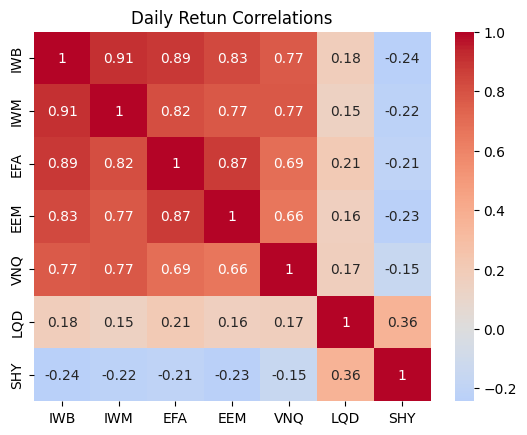

In [8]:
plot_corr('daily', returns, lower_only=False)

### Weekly Stats

In [9]:
calc_stats('weekly', returns)

,Avg Return,Std Dev,Return/Risk,Skewness,Kurtosis,10th Pct,25th Pct,50th Pct,75th Pct,90th Pct,CVaR90,CVaR95
IWB,0.19%,2.62%,7.20%,-130.44%,"1,130.32%",-2.69%,-0.77%,0.41%,1.55%,2.62%,-4.94%,-6.69%
IWM,0.15%,3.37%,4.34%,-108.40%,922.61%,-3.51%,-1.36%,0.38%,1.90%,3.61%,-6.33%,-8.47%
EFA,0.10%,2.81%,3.45%,-116.95%,795.93%,-3.06%,-1.02%,0.27%,1.63%,2.98%,-5.52%,-7.30%
EEM,0.10%,3.68%,2.74%,-97.65%,953.03%,-3.75%,-1.65%,0.35%,2.11%,3.72%,-6.78%,-9.06%
VNQ,0.13%,3.87%,3.26%,-163.45%,"2,085.76%",-3.44%,-1.28%,0.44%,1.90%,3.49%,-7.08%,-10.01%
LQD,0.08%,1.25%,6.06%,-120.85%,"4,270.85%",-1.07%,-0.40%,0.15%,0.62%,1.07%,-2.04%,-2.79%
SHY,0.03%,0.19%,17.90%,55.74%,576.69%,-0.15%,-0.06%,0.02%,0.11%,0.24%,-0.29%,-0.40%


In [26]:
# plot_corr('weekly', returns, lower_only=False)

### Monthly Stats

In [11]:
calc_stats('monthly', returns)

,Avg Return,Std Dev,Return/Risk,Skewness,Kurtosis,10th Pct,25th Pct,50th Pct,75th Pct,90th Pct,CVaR90,CVaR95
IWB,0.79%,4.73%,16.70%,-69.64%,350.61%,-4.59%,-1.40%,1.41%,3.50%,5.43%,-9.20%,-12.23%
IWM,0.61%,6.50%,9.43%,-35.05%,222.07%,-7.41%,-3.25%,0.85%,4.40%,7.75%,-12.11%,-15.52%
EFA,0.41%,5.30%,7.68%,-56.27%,242.74%,-6.05%,-1.94%,0.93%,3.51%,5.51%,-10.77%,-13.61%
EEM,0.43%,6.38%,6.72%,-11.81%,196.81%,-7.10%,-2.86%,0.31%,4.62%,7.77%,-11.58%,-14.41%
VNQ,0.54%,7.30%,7.46%,-110.61%,617.03%,-7.59%,-1.88%,1.29%,4.53%,7.14%,-14.27%,-19.45%
LQD,0.32%,2.14%,14.98%,-52.61%,747.25%,-1.96%,-0.70%,0.43%,1.59%,2.37%,-3.62%,-4.79%
SHY,0.14%,0.40%,35.36%,66.63%,341.18%,-0.22%,-0.07%,0.08%,0.33%,0.58%,-0.50%,-0.70%


In [27]:
# plot_corr('monthly', returns, lower_only=False)

### Quarterly Stats

In [13]:
calc_stats('quarterly', returns)

,Avg Return,Std Dev,Return/Risk,Skewness,Kurtosis,10th Pct,25th Pct,50th Pct,75th Pct,90th Pct,CVaR90,CVaR95
IWB,2.34%,8.90%,26.35%,-114.96%,391.29%,-7.22%,-1.16%,3.87%,8.04%,10.66%,-17.88%,-24.41%
IWM,1.81%,11.38%,15.94%,-80.64%,354.47%,-9.38%,-2.89%,2.98%,7.40%,12.80%,-23.21%,-31.57%
EFA,1.21%,9.83%,12.28%,-59.57%,289.67%,-12.08%,-2.71%,3.42%,7.21%,10.48%,-19.31%,-25.50%
EEM,1.26%,11.60%,10.83%,-48.18%,254.08%,-13.17%,-5.11%,2.42%,8.25%,12.49%,-21.92%,-31.04%
VNQ,1.58%,11.80%,13.44%,-208.38%,"1,094.72%",-10.97%,-3.44%,2.67%,8.75%,12.43%,-23.25%,-36.27%
LQD,0.94%,3.42%,27.43%,-40.80%,111.84%,-2.76%,-0.88%,1.12%,3.07%,5.09%,-6.06%,-8.09%
SHY,0.42%,1.01%,41.37%,66.47%,277.18%,-0.33%,0.00%,0.17%,0.78%,1.85%,-1.28%,-2.07%


In [28]:
# plot_corr('quarterly', returns, lower_only=False)

### Yearly Stats

In [15]:
calc_stats('yearly', returns)

,Avg Return,Std Dev,Return/Risk,Skewness,Kurtosis,10th Pct,25th Pct,50th Pct,75th Pct,90th Pct,CVaR90,CVaR95
IWB,9.15%,16.95%,54.01%,-187.48%,408.80%,-7.38%,2.92%,14.29%,20.30%,23.80%,-42.82%,nan%
IWM,7.16%,17.19%,41.65%,-102.70%,105.04%,-9.93%,-4.32%,10.71%,20.17%,24.68%,-37.70%,nan%
EFA,4.61%,18.12%,25.44%,-172.70%,404.29%,-11.92%,-4.47%,8.90%,16.06%,22.78%,-51.34%,nan%
EEM,4.87%,25.92%,18.78%,-66.60%,102.15%,-18.63%,-13.04%,13.38%,22.79%,29.15%,-61.67%,nan%
VNQ,6.60%,21.00%,31.45%,-89.07%,73.76%,-22.23%,-0.69%,7.76%,24.36%,29.39%,-45.93%,nan%
LQD,3.88%,6.68%,58.16%,-102.95%,211.10%,-2.19%,-0.29%,4.72%,8.80%,9.51%,-14.69%,nan%
SHY,1.71%,2.37%,71.91%,51.28%,108.36%,-0.06%,0.35%,1.39%,3.20%,4.24%,-3.16%,nan%


In [29]:
# plot_corr('yearly', returns, lower_only=False)

### Additional Plots Used for Analysis

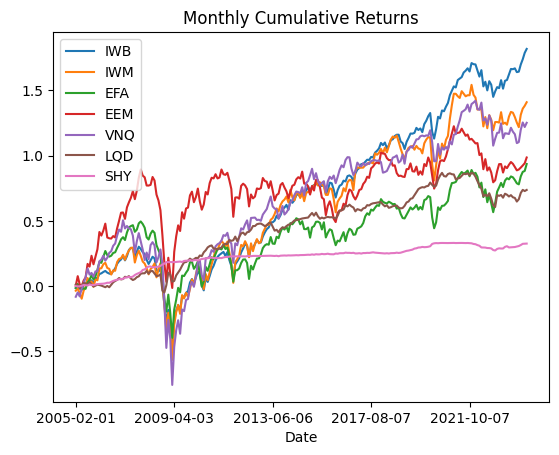

In [17]:
plot_time_series('monthly', returns)

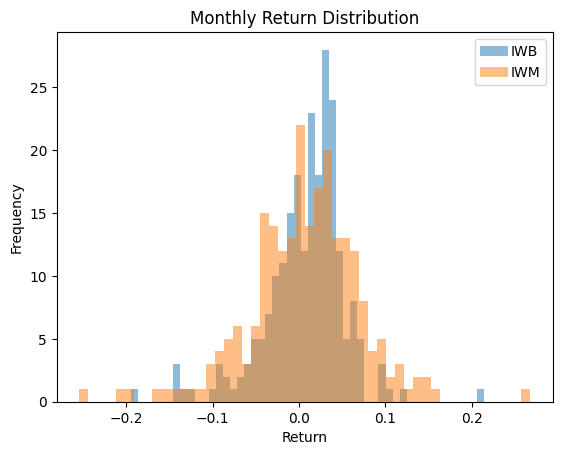

In [25]:
plot_hist('monthly', returns, tickers=['IWB', 'IWM'])